In [ ]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import os
import requests
import pickle
import uuid
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import plotly.express as px
from imdb import IMDb
from imdb._exceptions import IMDbDataAccessError
import json
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException


### Extracting movie IDs

In [ ]:
from imdb import IMDb

ia = IMDb() # Initialising API Instance

In [ ]:
def setup_driver():
    chrome_options = Options()
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--window-size=1920,1080")
    chrome_options.add_argument("user-agent=Mozilla/5.0")

    return webdriver.Chrome(options=chrome_options)
s
def get_imdb_ids_dynamic(load_more_clicks=3):
    imdb_ids = set()
    driver = setup_driver()

    url = "https://www.imdb.com/search/title/?genres=sci-fi&release_date=2024-01-01,2024-12-31&title_type=movie"
    driver.get(url)
    wait = WebDriverWait(driver, 10)

    for i in range(load_more_clicks):
        try:
            print(f"[+] Clicking 'Load More' button: Attempt {i+1}")
            button = wait.until(EC.element_to_be_clickable(
                (By.CLASS_NAME, "ipc-see-more__button")
            ))
            driver.execute_script("arguments[0].click();", button)
            time.sleep(2)  # Wait for new results to load
        except Exception as e:
            print(f"[!] Failed to click load more: {e}")
            break

    # After loading everything, grab all movie links
    a_tags = driver.find_elements(By.CSS_SELECTOR, "a.ipc-title-link-wrapper")
    for a in a_tags:
        href = a.get_attribute("href")
        match = re.search(r"/title/(tt\d+)/", href)
        if match:
            imdb_ids.add(match.group(1))

    driver.quit()
    return list(imdb_ids)

# Run it
ids = get_imdb_ids_dynamic(load_more_clicks=25)
print(f"\n✅ Total IMDb IDs collected after clicking 'Load More': {len(set(ids))}")
print(ids)

## Saving Movie IDs

In [ ]:
with open("movie_ids.pkl", "wb") as f:
    pickle.dump(ids, f)

## Saving Movie Titles with IDs [ID -> Key, Movie Name -> Value]

In [ ]:
# Setup IMDbPY with longer timeout
ia = IMDb()
ia.http_timeout = 20

# Safe wrapper with retry
def safe_get_movie_title(movie_id, max_retries=3):
    for attempt in range(max_retries):
        try:
            movie = ia.get_movie(int(movie_id[2:]))  # remove 'tt' and cast to int
            return movie.get('title')
        except IMDbDataAccessError as e:
            print(f"[!] IMDbPY timeout for {movie_id} (attempt {attempt+1}): {e}")
            time.sleep(2)  # wait before retry
        except Exception as e:
            print(f"[!] General error for {movie_id}: {e}")
            break
    return None  # if all retries fail

# Load movie IDs
with open("Movie_Information/movie_ids.pkl", "rb") as f:
    ids = pickle.load(f)

print(f"Total movie IDs: {len(ids)}")

titles = {}
for i, imdb_id in enumerate(ids, 1):
    print(f"Processing ({i}/{len(ids)}): {imdb_id}")
    title = safe_get_movie_title(imdb_id)
    if title:
        titles[imdb_id] = title
    else:
        print(f"[!] Skipped {imdb_id} due to repeated failure.")

# Save the dictionary
with open("Movie_Information/titles_ids.pkl", "wb") as f:
    pickle.dump(titles, f)

print(f"\nSaved {len(titles)} titles successfully.")

## Extracting Review Data from Saved Webpages (IMDB)

In [ ]:
with open("Movie_Information/titles_ids.pkl","rb") as f:
    titles = pickle.load(f)

def click_all_reviews_button(driver):
    try:
        # Wait for the All button to be present and visible -> All button is at the end of the page for movies which have more than 25 reviews (rule of thumb)
        all_button = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//button[.//span[text()='All']]"))
        )
        driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'center'});", all_button)
        time.sleep(1)

        # Wait for any overlays to disappear
        WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH, "//button[.//span[text()='All']]")))

        # Use JavaScript to click the button (bypasses visual obstruction)
        driver.execute_script("arguments[0].click();", all_button)
        print("Clicked 'All' button using JavaScript.")
        time.sleep(3)

    except Exception as e:
        print(f"[!] Could not click 'All' button: {e}")


def click_all_load_more(driver, max_clicks=100):
    """
    Continuously clicks the "Load More" button on the IMDB review page
    until it's gone or max_clicks is reached.
    """
    for i in range(max_clicks):
        try:
            load_more = driver.find_element(By.CLASS_NAME, "ipc-see-more__button")

            if load_more.get_attribute("aria-disabled") == "true":
                print("Load more button is disabled. Done.")
                break

            driver.execute_script("arguments[0].scrollIntoView(true);", load_more)
            time.sleep(1.5)
            load_more.click()
            print(f"Clicked Load More ({i+1})")
            time.sleep(2.5)

        except NoSuchElementException:
            print("No more Load More button found.")
            break
        except ElementClickInterceptedException:
            print("Scroll attempt to fix intercepted click.")
            driver.execute_script("window.scrollBy(0, 300);")
            time.sleep(1)
        except Exception as e:
            print(f"[!] Unexpected error: {e}")
            break

def expand_all_spoilers(driver):
    try:
        spoiler_buttons = driver.find_elements(By.XPATH, "//span[text()='Spoiler']/ancestor::button")
        print(f"🔍 Found {len(spoiler_buttons)} spoiler buttons.")
        for i, btn in enumerate(spoiler_buttons):
            try:
                driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'center'});", btn)
                driver.execute_script("arguments[0].click();", btn)
                time.sleep(0.5)
            except Exception as e:
                print(f"[!] Could not click spoiler {i+1}: {e}")
    except Exception as e:
        print(f"[!] Error expanding spoilers: {e}")


def extract_reviews_from_html(html):
    soup = BeautifulSoup(html, "html.parser")
    articles = soup.select("article.user-review-item")
    reviews = []

    for article in articles:
        try:
            # Title
            title_elem = article.select_one("h3.ipc-title__text")
            title = title_elem.text.strip() if title_elem else "N/A"

            # Body
            body_elem = (
                article.select_one("div.ipc-overflowText__children div.ipc-html-content-inner-div") or
                article.select_one("div[data-testid='review-overflow'] div.ipc-html-content-inner-div") or
                article.select_one("div[data-testid='review-content'] div.ipc-html-content-inner-div") or
                article.select_one("div.review-content div.ipc-html-content-inner-div")
            )
            if body_elem:
                for br in body_elem.find_all("br"):
                    br.replace_with("\n")
                body = body_elem.text.strip()
            else:
                body = "N/A"

            # Rating
            rating_elem = article.select_one("span.ipc-rating-star--rating")
            rating = rating_elem.text.strip() if rating_elem else "N/A"

            # Upvotes
            upvote_elem = article.select_one("span.ipc-voting__label span.ipc-voting__label__count.ipc-voting__label__count--up")
            upvotes = int(upvote_elem.text.strip()) if upvote_elem else 0

            # Downvotes
            downvote_elem = article.select_one("span.ipc-voting__label span.ipc-voting__label__count.ipc-voting__label__count--down")
            downvotes = int(downvote_elem.text.strip()) if downvote_elem else 0

            reviews.append({
                "title": title,
                "rating": rating,
                "body": body,
                "upvotes": upvotes,
                "downvotes": downvotes
            })

        except Exception as e:
            print("[!] Error parsing review:", e)

    return reviews

def paginate_reviews_dynamically(driver, max_attempts=100, pause_time=2.5):
    """
    Handles any form of dynamic pagination: "Load More", "6 more", infinite scroll.
    """
    last_count = 0
    same_count_attempts = 0

    for i in range(max_attempts):
        # First, try clicking any visible "more" button
        try:
            more_button = WebDriverWait(driver, 3).until(
                EC.element_to_be_clickable((By.XPATH, "//button[.//span[contains(text(), 'more')]]"))
            )
            driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'center'});", more_button)
            time.sleep(0.5)
            driver.execute_script("arguments[0].click();", more_button)
            print(f"🔁 Clicked 'More' button ({i + 1})")
            time.sleep(pause_time)
            continue  # Retry to catch next button
        except:
            pass  # No button found, proceed with scroll fallback

        # Scroll as fallback to trigger lazy loading
        driver.execute_script("window.scrollBy(0, 1000);")
        time.sleep(pause_time)

        current_count = len(driver.find_elements(By.CSS_SELECTOR, "article.user-review-item"))
        print(f"Scroll check {i + 1}: {current_count} reviews visible.")

        if current_count == last_count:
            same_count_attempts += 1
        else:
            same_count_attempts = 0
            last_count = current_count

        if same_count_attempts >= 5:
            print("No more reviews loading — ending pagination.")
            break
    else:
        print("Max attempts reached — pagination may be incomplete.")

def scroll_to_load_all_reviews(driver, pause_time=3.0, max_scrolls=1, scroll_step=1000):
    """
    Scrolls down the page incrementally to trigger dynamic loading of reviews.
    """
    last_count = 0
    attempts = 0

    for i in range(max_scrolls):
        driver.execute_script(f"window.scrollBy(0, {scroll_step});")
        time.sleep(pause_time)

        # Optional: track number of loaded reviews
        current_count = len(driver.find_elements(By.CSS_SELECTOR, "article.user-review-item"))

        if current_count == last_count:
            attempts += 1
        else:
            attempts = 0
            last_count = current_count

        # Stop if no new reviews for N attempts
        if attempts >= 3:
            print("No new reviews loading — stopping scroll.")
            break
    else:
        print("Max scroll limit reached — possibly incomplete.")


def scrape_reviews_selenium(save_path="Reviews"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    driver = webdriver.Chrome()
    
    try:
        for imdb_id, title in titles.items():
            url = f"https://www.imdb.com/title/{imdb_id}/reviews"

            try:
                driver.get(url)
                time.sleep(2)
                review_count_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='tturv-total-reviews']")
                review_text = review_count_elem.text.strip()
                review_num = int(review_text.split()[0].replace(",", ""))
                if review_num == 0:
                    print(f"Skipping {title} ({imdb_id}) — 0 reviews found.")
                    continue
                
                if (review_num > 25):

                    print("Clicking 'All' button to load full review mode...")
                    click_all_reviews_button(driver)

                    print("Paginating through dynamic review blocks...")
                    paginate_reviews_dynamically(driver)

                    print("Expanding spoiler tagged reviews...")
                    expand_all_spoilers(driver)

                    print("Extracting reviews from fully loaded page...")
                    html = driver.page_source
                    reviews = extract_reviews_from_html(html)

                    print(f"Total reviews scraped: {len(reviews)}")

                    with open(f"{save_path}/{imdb_id}_reviews.pkl", "wb") as f:
                        pickle.dump(reviews, f)
                    print(f"Saved: {save_path}/{imdb_id}_reviews.pkl")
                    
                else:
                    
                    print("Expanding spoiler tagged reviews...")
                    expand_all_spoilers(driver)

                    print("Extracting reviews from fully loaded page...")
                    html = driver.page_source
                    reviews = extract_reviews_from_html(html)

                    print(f"Total reviews scraped: {len(reviews)}")

                    with open(f"{save_path}/{imdb_id}_reviews.pkl", "wb") as f:
                        pickle.dump(reviews, f)
                    print(f"Saved: {save_path}/{imdb_id}_reviews.pkl")

            except Exception as e:
                print(f"[!] Error scraping {imdb_id}: {e}")

    finally:
        driver.quit()
        
scrape_reviews_selenium()

## Extracting Metadata from Saved Webpages (IMDB)

In [ ]:
## === Take note that we only extract metadata for movies which have len(reviews) >= 1. Filtering is done through the output of the previous cell === ##

def get_saved_imdb_ids(directory, extension=".pkl"):
    saved_ids = set()
    for filename in os.listdir(directory):
        if filename.endswith(extension):
            imdb_id = os.path.splitext(filename)[0]  # remove file extension
            imdb_id = imdb_id.split("_")[0]
            saved_ids.add(imdb_id)
    return saved_ids

ids = get_saved_imdb_ids("Reviews") # Valid IDs for movies which have reviews

problematic_imdbs = []
    
def scroll_until_element_found(driver, by, selector, max_scrolls=20, scroll_pause=1):
    for _ in range(max_scrolls):
        try:
            element = driver.find_element(by, selector)
            return element
        except NoSuchElementException:
            driver.execute_script("window.scrollBy(0, 1000);")
            time.sleep(scroll_pause)
    return None

def scrape_meta_information_selenium(save_path="Filtered_MetaData"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    driver = webdriver.Chrome()
    
    count = 0

    try:
        for imdb_id in ids:
            meta_information = {}
            interest_tags_data = []
            url = f"https://www.imdb.com/title/{imdb_id}"

            try:
                driver.get(url)
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.TAG_NAME, "body"))
                )
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-testid='hero-rating-bar__aggregate-rating__score']"))
                )

                # --- Interest Tags ---
                try:
                    interest_tags = driver.find_elements(By.CSS_SELECTOR, "a.ipc-chip.ipc-chip--on-baseAlt")
                    for tag in interest_tags:
                        span = tag.find_element(By.CLASS_NAME, "ipc-chip__text")
                        interest_tags_data.append(span.text.strip())
                    meta_information['Interest_Tags'] = interest_tags_data if interest_tags_data else "N/A"
                except Exception as e:
                    meta_information['Interest_Tags'] = "N/A"

                # --- IMDb Rating ---
                try:
                    rating_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='hero-rating-bar__aggregate-rating__score'] span")
                    meta_information['IMDB_Rating'] = rating_elem.text.strip()
                except Exception as e:
                    meta_information['IMDB_Rating'] = "N/A"

                # --- Number of Votes ---
                try:
                    rating_block = driver.find_element(
                        By.CSS_SELECTOR,
                        "div[data-testid='hero-rating-bar__aggregate-rating__score']"
                    ).find_element(By.XPATH, "../..")

                    vote_candidates = rating_block.find_elements(By.TAG_NAME, "div")
                    num_votes = "N/A"
                    
                    for div in vote_candidates:
                        text = div.text.strip().replace(",", "")
                        if text.isdigit():
                            num_votes = text
                            break
                    
                    meta_information["Num_Votes"] = num_votes
                except Exception as e:
                    meta_information["Num_Votes"] = "N/A"


                # --- Current popularity ---
                try:
                    pop_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='hero-rating-bar__popularity__score']")
                    meta_information["Popularity_Score"] = pop_elem.text.strip()
                except Exception as e:
                    meta_information["Popularity_Score"] = "N/A"

                # --- Credits Section (Director, Writers, Stars) ---
                try:
                    credits = driver.find_elements(By.CSS_SELECTOR, "li[data-testid='title-pc-principal-credit']")

                    # Director
                    try:
                        director_links = credits[0].find_elements(By.CSS_SELECTOR, "ul li a")
                        meta_information["Director(s)"] = [a.text.strip() for a in director_links if a.text.strip()]
                    except:
                        meta_information["Director(s)"] = "N/A"

                    # Writer
                    try:
                        writer_links = credits[1].find_elements(By.CSS_SELECTOR, "ul li a")
                        meta_information["Writer(s)"] = [a.text.strip() for a in writer_links if a.text.strip()]
                    except:
                        meta_information["Writer(s)"] = "N/A"

                    # Stars
                    try:
                        star_links = credits[2].find_elements(By.CSS_SELECTOR, "ul li a")
                        meta_information["Star(s)"] = [a.text.strip() for a in star_links if a.text.strip()]
                    except:
                        meta_information["Star(s)"] = "N/A"

                except Exception as e:
                    meta_information["Director(s)"] = "N/A"
                    meta_information["Writer(s)"] = "N/A"
                    meta_information["Star(s)"] = "N/A"

                # --- Review Counts ---
                try:
                    user_reviews = critic_reviews = "N/A"
                    review_blocks = driver.find_elements(By.CSS_SELECTOR, "span.three-Elements")
                    for block in review_blocks:
                        label = block.find_element(By.CLASS_NAME, "label").text.strip()
                        score = block.find_element(By.CLASS_NAME, "score").text.strip()
                        if "User" in label:
                            user_reviews = score
                        elif "Critic" in label:
                            critic_reviews = score
                    meta_information["Num_User_Reviews"] = user_reviews
                    meta_information["Num_Critic_Reviews"] = critic_reviews
                except Exception as e:
                    meta_information["Num_User_Reviews"] = "N/A"
                    meta_information["Num_Critic_Reviews"] = "N/A"

                # --- MetaScore ---
                try:
                    metascore_elem = driver.find_element(By.CSS_SELECTOR, "span.metacritic-score-box")
                    meta_information["MetaScore"] = metascore_elem.text.strip()
                except Exception as e:
                    meta_information["MetaScore"] = "N/A"

                # --- Streaming Service ---
                try:
                    streaming_elem = driver.find_element(By.CSS_SELECTOR, "a[aria-label^='Watch on']")
                    label = streaming_elem.get_attribute("aria-label")
                    meta_information["Streaming_Service"] = label.replace("Watch on ", "").strip()
                except Exception as e:
                    meta_information["Streaming_Service"] = "N/A"

                # --- Storyline ---
                try:
                    # Scroll until Storyline section is found
                    storyline_section = scroll_until_element_found(driver, By.XPATH, "//section[@data-testid='Storyline']")

                    if storyline_section:
                        storyline_elem = storyline_section.find_element(
                            By.CSS_SELECTOR,
                            "div[data-testid='storyline-plot-summary'] div.ipc-html-content-inner-div"
                        )
                        storyline = storyline_elem.text.strip()
                        meta_information["Storyline"] = storyline
                    else:
                        raise Exception("Storyline section not found after scrolling.")
                except Exception as e:
                    meta_information["Storyline"] = "N/A"

                # --- Tagline ---
                try:
                    tagline_elem = driver.find_element(By.CSS_SELECTOR, "[data-testid='storyline-taglines']")
                    meta_information["Tagline"] = tagline_elem.text.strip()
                except Exception as e:
                    meta_information["Tagline"] = "N/A"

                # --- Genres ---
                try:
                    genres_elem = driver.find_element(By.CSS_SELECTOR, "[data-testid='storyline-genres']")
                    genre_links = genres_elem.find_elements(By.CSS_SELECTOR, "ul li a")
                    genres = [link.text.strip() for link in genre_links if link.text.strip()]
                    meta_information["Genres"] = genres if genres else "N/A"
                except Exception as e:
                    genres = "N/A"
                    meta_information["Genres"] = genres

                # Scroll until "Details" section is found
                details_section = scroll_until_element_found(
                    driver,
                    By.XPATH,
                    "//section[@data-testid='Details']"
                )

                if not details_section:
                    print("No Details Section Found")

                # --- Release Date ---
                try:
                    release_elem = details_section.find_element(
                        By.CSS_SELECTOR,
                        "li[data-testid='title-details-releasedate'] ul li a"
                    )
                    release_date = release_elem.text.strip()
                    meta_information["Release_Date"] = release_date
                except Exception as e:
                    print("Could not extract release date.")
                    meta_information["Release_Date"] = "N/A"

                # --- Country of Origin ---
                try:
                    country_links = details_section.find_elements(
                        By.CSS_SELECTOR,
                        "li[data-testid='title-details-origin'] ul li a"
                    )
                    countries = [link.text.strip() for link in country_links if link.text.strip()]
                    meta_information["Country_of_Origin"] = countries if countries else "N/A"
                except Exception as e:
                    print("Could not extract countries of origin.")
                    meta_information["Country_of_Origin"] = "N/A"

                # --- Language(s) ---
                try:
                    language_links = details_section.find_elements(
                        By.CSS_SELECTOR,
                        "li[data-testid='title-details-languages'] ul li a"
                    )
                    languages = [link.text.strip() for link in language_links if link.text.strip()]
                    meta_information["Language"] = languages if languages else "N/A"
                except Exception as e:
                    print("Could not extract language(s).")
                    meta_information["Language"] = "N/A"
                    
                # --- Box Office Info ---
                try:
                    # box_office_section = scroll_until_element_found(driver, By.XPATH, "//section[@data-testid='BoxOffice']")
                    
                    box_office_section = driver.find_element(By.XPATH, "//section[@data-testid='BoxOffice']")


                    if box_office_section:
                        box_office_items = box_office_section.find_elements(By.CSS_SELECTOR, "li.ipc-metadata-list__item")

                        for item in box_office_items:
                            try:
                                label = item.find_element(By.CSS_SELECTOR, "span.ipc-metadata-list-item__label").text.strip()

                                # Navigate to the deeply nested content span (actual number value)
                                value = item.find_element(By.CSS_SELECTOR, "div.ipc-metadata-list-item__content-container ul li span").text.strip()

                                meta_information[label] = value
                            except Exception:
                                continue
                    else:
                        raise Exception("BoxOffice section not found.")

                except Exception as e:
                    print(f"Could not extract box office data: {e}")
                    
                # --- Runtime ---
                try:
                    runtime_section = driver.find_element(By.XPATH, "//section[@data-testid='TechSpecs']")

                    if runtime_section:
                        runtime_elem = runtime_section.find_element(
                            By.CSS_SELECTOR,
                            "li[data-testid='title-techspec_runtime'] div.ipc-metadata-list-item__content-container"
                        )
                        runtime = runtime_elem.text.strip()  # Will give something like: "2 hours 46 minutes"
                        meta_information["Runtime"] = runtime
                    else:
                        raise Exception("TechSpecs section not found.")

                except Exception as e:
                    print("Could not extract runtime:", e)
                    meta_information["Runtime"] = "N/A"
                
                # Save to file
                with open(f"{save_path}/{imdb_id}_meta.pkl", "wb") as f:
                    pickle.dump(meta_information, f)
                print(f"Saved: {save_path}/{imdb_id}_meta.pkl")
                count += 1
                print(f"{count}/{len(ids)} Movies' MetaData Processed")
                print("\n")

            except Exception as e:
                print(f"[!] Error scraping {imdb_id}: {e}")
                problematic_imdbs.append(imdb_id)

    finally:
        driver.quit()

scrape_meta_information_selenium()

In [ ]:
with open("Movie_Information/titles_ids.pkl","rb") as f:
    titles = pickle.load(f)
    
directory = "Reviews"

all_review_information = {}

for imdb_id, title in titles.items():
    filename = f"{imdb_id}_reviews.pkl"
    file_path = os.path.join(directory, filename)
    if os.path.exists(file_path): 
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_review_information[title] = data
            
with open("Final_Data/all_review_information.json", "w", encoding="utf-8") as f:
    json.dump(all_review_information,f, ensure_ascii=False,indent=2)
    
print(f"Saved Review Data for {len(all_review_information)} titles.")

In [ ]:
all_review_metadata = {}
directory = "Filtered_MetaData"

for imdb_id, title in titles.items():
    filename = f"{imdb_id}_meta.pkl"
    file_path = os.path.join(directory, filename)

    if os.path.exists(file_path): 
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            all_review_metadata[title] = data

os.makedirs("Final_Data", exist_ok=True)

with open("Final_Data/all_review_metadata.json", "w", encoding="utf-8") as f:
    json.dump(all_review_metadata, f, ensure_ascii=False, indent=2)

print(f"Saved MetaData for {len(all_review_metadata)} titles.")

### An additional sanity check is done to ensure that no movies which have 0 reviews are included in the data

In [ ]:
with open("Final_Data/all_review_information.json","r") as f:
    info = json.load(f)
    
with open("Final_Data/all_review_metadata.json","r") as f:
    meta = json.load(f)
    
# First, keep all movies in info which DO NOT have 0 reviews

info = {k: v for k, v in info.items() if v != []}

# Make sure meta is changed accordingly as well
meta = {k: v for k, v in meta.items() if k in info}

with open("Final_Data/all_review_information_filtered.json","w", encoding="utf-8") as f:
    json.dump(info,f, ensure_ascii=False, indent=2)
    
with open("Final_Data/all_review_metadata_filtered.json", "w", encoding="utf-8") as f:
    json.dump(meta,f, ensure_ascii=False, indent=2)

### Information pertaining to data collected

In [ ]:
import glob
from collections import Counter

review_files = glob.glob("Reviews/*.pkl")
num_records = len(review_files)
print(f"Total number of review documents: {num_records}")

total_reviews = 0
for file in review_files:
    with open(file, "rb") as f:
        data = pickle.load(f)
        total_reviews += len(data) 

print(f"Total number of individual reviews: {total_reviews}")

word_counter = Counter()

for file in review_files:
    with open(file, "rb") as f:
        reviews = pickle.load(f)
        for review in reviews:
            text = review.get("body", "")
            words = re.findall(r'\b\w+\b', text.lower())
            word_counter.update(words)

total_words = sum(word_counter.values())
unique_words = len(word_counter)

print(f"Total words (tokens): {total_words}")
print(f"Unique words (types): {unique_words}")

## Data Indexing Pipeline Begins Here

In [ ]:
# Initialising Solr through python wrapper pysolr
from urllib import *
import pysolr
solr = pysolr.Solr('http://localhost:8983/solr/moviereviewscore', always_commit=True)

In [ ]:
response = solr.ping()
parsed = json.loads(response)
print("Solr Ping Status:", parsed["status"]) # Should be 'OK'
print("Response Time (ms):", parsed["responseHeader"]["QTime"])

### Helper functions for pre-processing review data and metadata

In [ ]:
def safe_float(value, fallback=-1.0): # Helper function to handle reviews with NULL Ratings
    try:
        if value is None:
            return fallback
        value_str = str(value).strip()
        if value_str.lower() in ["", "n/a", "none", "null"]:
            return fallback
        return float(value_str)
    except (ValueError, TypeError):
        return fallback

def parse_currency(value_str):
    try:
        # Extract the first occurrence of a numeric pattern (with optional commas and decimals)
        match = re.search(r"[\d,]+(?:\.\d+)?", value_str)
        if match:
            number_str = match.group().replace(",", "")
            return float(number_str)
    except:
        pass
    return 0

def parse_runtime(runtime_str):
    try:
        hours = minutes = 0
        match = re.findall(r'(\d+)\s*(hour|minute)', runtime_str)
        for amount, unit in match:
            if 'hour' in unit:
                hours = int(amount)
            elif 'minute' in unit:
                minutes = int(amount)
        
        return hours * 60 + minutes
    
    except:
        return 0
    
def parse_release_date(date_str):
    try:
        match = re.match(r"([A-Za-z]+ \d{1,2}, \d{4})(?: \((.*?)\))?", date_str)
        if not match:
            return None, "N/A"
        
        raw_date, country = match.groups()
        parsed_date = datetime.strptime(raw_date.strip(), "%B %d, %Y")
        return parsed_date.strftime("%Y-%m-%dT00:00:00Z"), country or "N/A" # For compatibility with Solr
    except Exception:
        return None, "N/A"

import hashlib

def generate_doc_id(movie_name, review_body):
    unique_str = f"{movie_name}::{review_body}::{time.time()}".encode('utf-8') # To ensure unique ids, we hash movie name, review body, and timestamp
    return hashlib.md5(unique_str).hexdigest()



def prepare_solr_document(meta, title, body, movie_name, positive_ratings, negative_ratings):
    def ensure_list(val):
        return val if isinstance(val, list) else [val] if val else ["N/A"]

    parsed_date, release_country = parse_release_date(meta.get("Release_Date", ""))
    
    doc = {
        "id": generate_doc_id(movie_name, body),
        "title": title,
        "body": body,
        "movie_name": movie_name,
        "movie_name_autocomplete": movie_name,
        "positive_user_ratings": safe_float(positive_ratings),
        "negative_user_ratings": safe_float(negative_ratings),

        # Float/numeric fields
        "imdb_rating": safe_float(meta.get("IMDB_Rating", -1)),
        "metascore": safe_float(meta.get("MetaScore", -1)),
        "budget": parse_currency(meta.get("Budget", "")),
        "gross_worldwide": parse_currency(meta.get("Gross worldwide", "")),
        "runtime_minutes": parse_runtime(meta.get("Runtime", "")),

        # MultiValued text fields (tokenized and copied for autocomplete)
        "directors": ensure_list(meta.get("Director(s)", [])),
        "writers": ensure_list(meta.get("Writer(s)", [])),
        "stars": ensure_list(meta.get("Star(s)", [])),
        "language": ensure_list(meta.get("Language", [])),
        "country_of_origin": ensure_list(meta.get("Country_of_Origin", [])),
        "release_date" : parsed_date,
        "release_country" : release_country
    }

    return doc

In [ ]:
def prepare_solr_document_metadata(meta, body, movie_name):
    def ensure_list(val):
        return val if isinstance(val, list) else [val] if val else ["N/A"]

    parsed_date, release_country = parse_release_date(meta.get("Release_Date", ""))
    
    doc = {
        "id": generate_doc_id(movie_name, body),
        "movie_name": movie_name,
        "movie_name_autocomplete": movie_name,

        # Float/numeric fields
        "imdb_rating": safe_float(meta.get("IMDB_Rating", -1)),
        "metascore": safe_float(meta.get("MetaScore", -1)),
        "budget": parse_currency(meta.get("Budget", "")),
        "gross_worldwide": parse_currency(meta.get("Gross worldwide", "")),
        "runtime_minutes": parse_runtime(meta.get("Runtime", "")),

        # MultiValued text fields (tokenized and copied for autocomplete)
        "directors": ensure_list(meta.get("Director(s)", [])),
        "writers": ensure_list(meta.get("Writer(s)", [])),
        "stars": ensure_list(meta.get("Star(s)", [])),
        "language": ensure_list(meta.get("Language", [])),
        "country_of_origin": ensure_list(meta.get("Country_of_Origin", [])),
        "release_date" : parsed_date,
        "release_country" : release_country
    }

    return doc

### Indexing of Data -> moviereviewscore

In [ ]:
with open("Final_Data/all_review_information_filtered.json","r") as f:
    info = json.load(f)
    
with open("Final_Data/all_review_metadata_filtered.json","r") as f:
    meta = json.load(f)
    
edge_cases = []
    
for movie_name in info:
    if (movie_name not in list(meta.keys())):
        edge_cases.append(movie_name)
        
if (len(edge_cases) == 0): # We are good to go for Indexing
    
    count = 0
    final_count = 0

    batch = []
    for movie_title in info:

        for review in info[movie_title]:
            doc = prepare_solr_document(meta[movie_title], review['title'], review['body'], movie_title, review['upvotes'], review['downvotes'])
            batch.append(doc)

            if len(batch) == 500:
                count += 500
                solr.add(batch)
                batch = []

    # Add any remaining
    if batch:
        final_count += len(batch)
        solr.add(batch)
        print(f"Final batch of {len(batch)} indexed.")

    print("Indexing complete!")
    print(f"A total of {count + final_count} documents have been indexed!")
    
else:
    print(f"Error prior to Indexing, there are {len(edge_cases)} movies which are erroneously present")

### Indexing of Data -> metadatacore

In [ ]:
solr = pysolr.Solr('http://localhost:8983/solr/metadatacore', always_commit=True)

response = solr.ping()
parsed = json.loads(response)
print("Solr Ping Status:", parsed["status"]) # Should be 'OK'
print("Response Time (ms):", parsed["responseHeader"]["QTime"])

In [ ]:
# ===== Following section is commented since the indexing was already done prior ===== #
with open("Final_Data/all_review_information_filtered.json","r") as f:
    info = json.load(f)
    
with open("Final_Data/all_review_metadata_filtered.json","r") as f:
    meta = json.load(f)
    
edge_cases = []
    
for movie_name in info:
    if (movie_name not in list(meta.keys())):
        edge_cases.append(movie_name)
        
if (len(edge_cases) == 0): # We are good to go for Indexing
    
    count = 0
    final_count = 0
    
    batch = []
    for movie_title in info:

        for review in info[movie_title]:
            doc = prepare_solr_document_metadata(meta[movie_title], review['body'], movie_title)
            batch.append(doc)

            if len(batch) == 500:
                solr.add(batch)
                count += 500
                batch = []

    # Add any remaining
    if batch:
        solr.add(batch)
        final_count += len(batch)
        print(f"Final batch of {len(batch)} indexed.")
    
    print("Indexing complete!")
    print(f"A total of {count + final_count} documents have been indexed!")
    
else:
    print(f"Error prior to Indexing, there are {len(edge_cases)} movies which are erroneously present")

## Data Distribution Visualisation

### Aggregation via Number of Reviews Per Movie

In [437]:
with open("Final_Data/all_review_information_filtered.json","r") as f:
    info = json.load(f)

review_count_per_movie = {}
upvote_downvote_per_review = {}
for title, reviews in info.items():
    review_count_per_movie[title] = len(reviews)

new_df = pd.DataFrame(columns = ['Title','Number of Reviews'])
new_df['Title'] = list(review_count_per_movie.keys())
new_df['Number of Reviews'] = list(review_count_per_movie.values())
print("=== Raw Plot for Number of Reviews Per Movie ===\n")

fig = px.line(
    new_df,
    x="Title",
    y="Number of Reviews",
    title="Box Plot of Review Counts per Movie",
    labels={"Number of Reviews": "Review Count"}
)
fig.show()

=== Raw Plot for Number of Reviews Per Movie ===



### We implement Log-Normalisation to view the trend better

In [438]:
print("=== Raw Plot for Log-Scaled Number of Reviews Per Movie ===\n")

new_df["Log Reviews"] = np.log1p(new_df["Number of Reviews"])

fig = px.histogram(
    new_df,
    x="Title",
    y ="Log Reviews",
    nbins=50,
    title="Log-Scaled Distribution of Reviews",
    labels={"Log Reviews": "log(1 + Review Count)"}
)
fig.show()

=== Raw Plot for Log-Scaled Number of Reviews Per Movie ===



### Graph for stopword frequency is generated below

1162


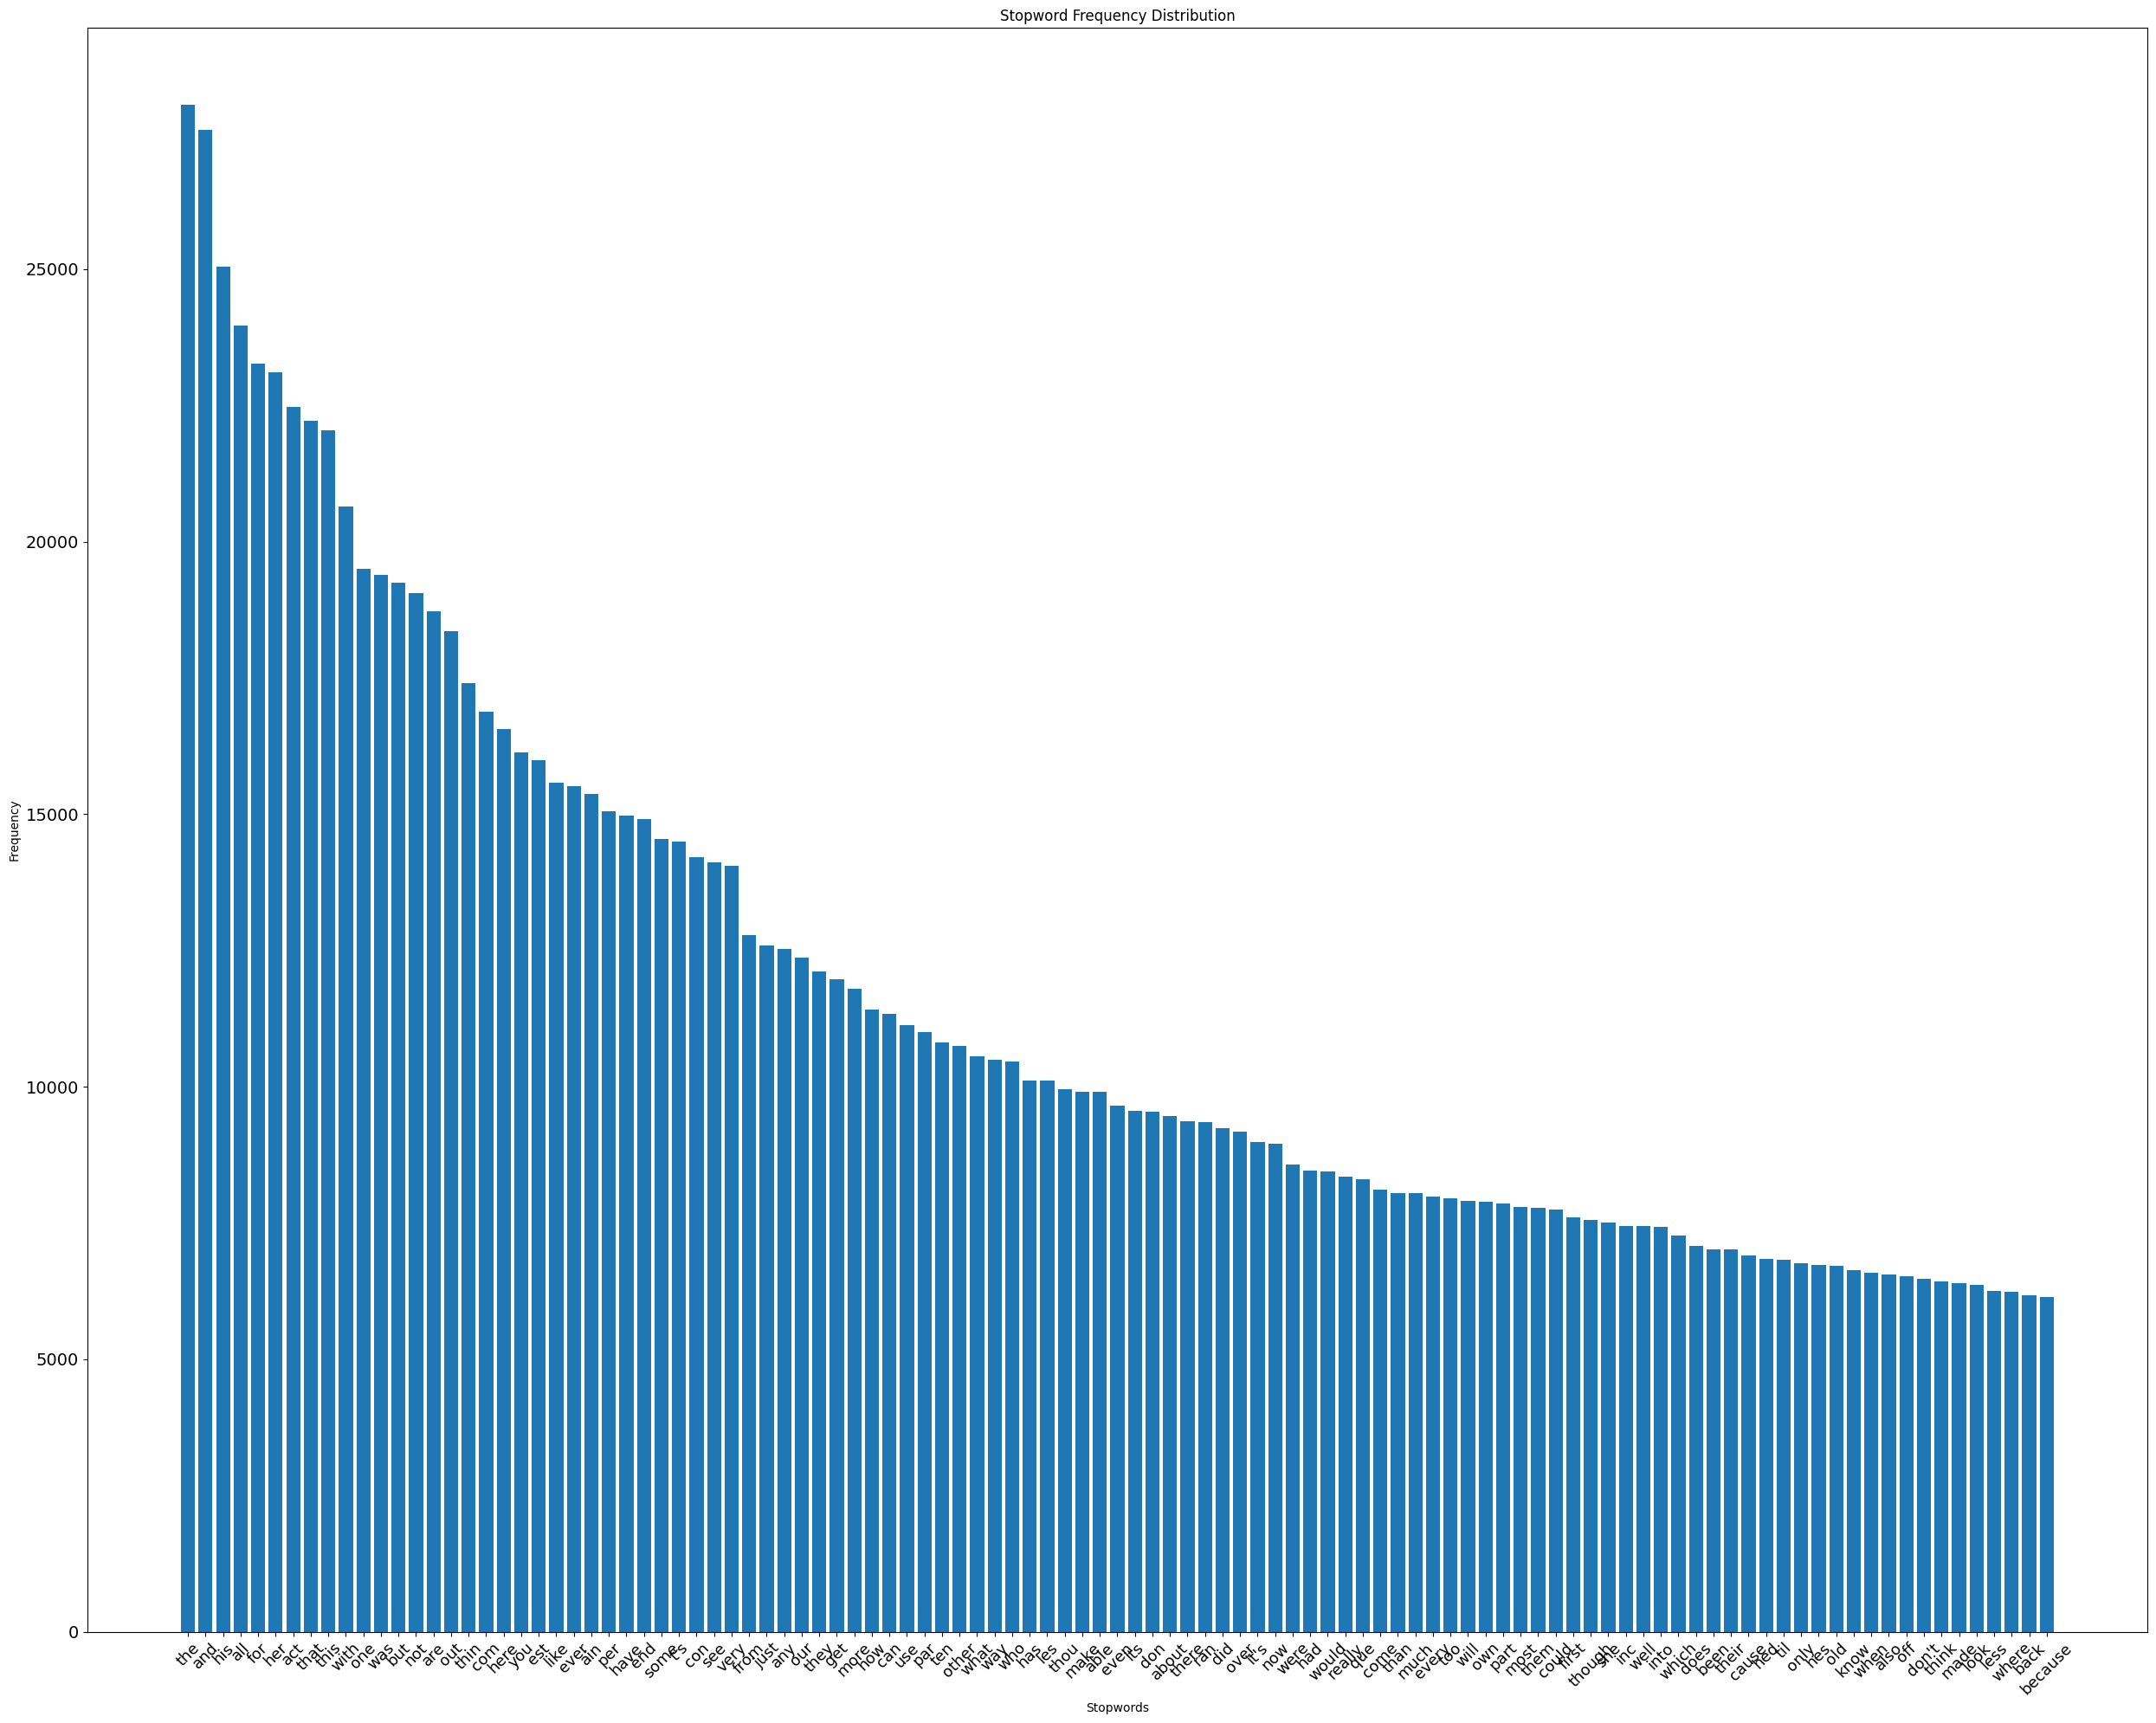

In [439]:
with open("Final_Data/all_review_information_filtered.json", "r") as f:
    reviews = json.load(f)

with open("Solr_Config_Data/stopwords_copy.txt","r") as f:
    stopwords = f.read()
    
stopwords = [x for x in stopwords.split("\n")]

print(len(stopwords))

# Microtext Data Graph
stopword_dict = {}
for movie_name,reviews in reviews.items():
    for review in reviews:
        for word in stopwords:
            if (len(word) <= 2):
                continue
            if (word in review['body']):
                if (word in stopword_dict.keys()):
                    stopword_dict[word] += 1
                else:
                    stopword_dict[word] = 1

words = list(stopword_dict.keys())
frequency = list(stopword_dict.values())
df = pd.DataFrame(data={'Stopwords': words,'Frequency':frequency})
cleaned = df.sort_values(by='Frequency',ascending=False)
cleaned.reset_index(inplace=True,drop=True)
removed_sparse = cleaned[~(cleaned['Frequency'] <= 6000)]

# Plotting
plt.figure(figsize=(25, 20))
plt.bar(removed_sparse['Stopwords'], removed_sparse['Frequency'])
plt.xlabel('Stopwords')
plt.ylabel('Frequency')
plt.title('Stopword Frequency Distribution')
plt.xticks(rotation=45)
plt.xticks(rotation=45, fontsize=13) 
plt.yticks(fontsize=14)               
plt.tight_layout()
plt.show()